In [ ]:
# importacion general de librerias y de visualizacion (matplotlib y seaborn)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import collections
from collections import Counter

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
nltk.download('punkt')
nltk.download('stopwords')

from PIL import Image

%matplotlib inline

plt.style.use('default') # haciendo los graficos un poco mas bonitos en matplotlib

sns.set(style="whitegrid") # seteando tipo de grid en seaborn

pd.options.display.float_format = '{:20,.2f}'.format # suprimimos la notacion cientifica en los outputs

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
#https://drive.google.com/file/d/1DJM8hLTqP35WpgkQNEjaom5N9U3BdIWe/view?usp=drive_link

id='1DJM8hLTqP35WpgkQNEjaom5N9U3BdIWe'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('customer_airways_data.csv')

In [ ]:
customer=pd.read_csv('customer_airways_data.csv',encoding='latin1')

In [ ]:
#https://drive.google.com/file/d/1IOeo5nGZV6Md1LQgZ8V0-S_IPctVeeef/view?usp=drive_link

id='1IOeo5nGZV6Md1LQgZ8V0-S_IPctVeeef'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('cleaned-reviews.csv')

In [ ]:
cleanReviews=pd.read_csv('cleaned-reviews.csv')

# **Limpieza de datos**

# **Customer**

In [ ]:
#cambiamos el nombre, ya que el merge se va hacer en base a country de ambos paises
customer = customer.rename(columns= {'booking_origin': 'country'})

In [ ]:
#Se elimina el pais "not set" ya que no es reconocido como pais
customer[customer.country == '(not set)']

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,country,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
252,2,Internet,RoundTrip,14,17,10,Sat,AKLKUL,(not set),1,0,0,8.83,1
1147,3,Internet,RoundTrip,40,17,0,Fri,AKLKUL,(not set),0,0,0,8.83,0
4547,1,Internet,RoundTrip,29,38,20,Wed,CKGTRZ,(not set),1,0,1,4.83,0
6311,2,Internet,RoundTrip,197,42,1,Thu,COKMEL,(not set),1,1,1,8.83,0
6518,2,Internet,RoundTrip,248,24,22,Fri,COKOOL,(not set),1,0,0,8.83,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45921,2,Internet,RoundTrip,60,6,11,Mon,HGHHKT,(not set),1,0,0,5.07,0
46007,1,Internet,RoundTrip,163,6,1,Mon,HGHSIN,(not set),0,0,0,5.07,0
46043,1,Internet,RoundTrip,5,6,14,Fri,HGHTRZ,(not set),1,1,0,5.07,1
46847,1,Internet,RoundTrip,46,6,16,Wed,HNDPEN,(not set),1,0,0,7.57,1


In [ ]:
customer.drop(customer[customer['country'] == '(not set)'].index, inplace=True)

## **CleanReviews**

In [ ]:
cleanReviews.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
#modificaremos este dataset y crear una entrada por pais (country) y sacar el promedio de rating (rate). Por otro lado joineamos todos los reviews
cleanReviews['average_rating'] = cleanReviews.groupby('country')['rates'].transform(lambda x: x.mean())

In [ ]:
##cleanReviews['reviews'] = cleanReviews['reviews'].str.split('|', expand = True)[1]

In [ ]:
cleanReviews['fecha'] = pd.to_datetime(cleanReviews['date'])
cleanReviews['year'] = cleanReviews['fecha'].dt.year
cleanReviews['month'] = cleanReviews['fecha'].dt.month

In [ ]:
#Como vamos a trabajar con la col comment, vamos a crear una col tokenizada para a futuro usarlo

# Preprocesa los comentarios

def procesadorDeComentario(comment):
    # Convierte el comentario a minúsculas
    comment = comment.lower()

    # Elimina signos de puntuación
    comment = comment.translate(str.maketrans('', '', string.punctuation))

    # Tokeniza el comentario
    tokens = word_tokenize(comment)

    # Elimina palabras vacías (stopwords) y tokens cortos
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words and len(word) > 3]

    return tokens

In [ ]:
# Aplica la función de preprocesamiento a los comentarios
cleanReviews['tokens'] = cleanReviews['comments'].apply(procesadorDeComentario)

In [ ]:
total_nans = cleanReviews.isna().sum().sum()
print(f"Total de NaN en el DataFrame: {total_nans}")

Total de NaN en el DataFrame: 0


In [ ]:
#cleanReviews['join_reviews'] = cleanReviews.groupby('country')['reviews'].apply(lambda row: ' '.join(row.astype(str)))
joinReviewPorPais = cleanReviews.groupby('country')['comments'].agg(lambda x: ' '.join(x)).reset_index()
joinReviewPorPais

,country,comments
0,Argentina,frankfurt buenos aire via london october aircr...
1,Australia,verified good flight apart seat fabric coming ...
2,Austria,london vienna shocked ba provides buy onboard ...
3,Bahrain,unverified always given fair review airline ba...
4,Barbados,avelled barbados london gatwick onwards italy ...
...,...,...
64,Ukraine,flew kiev london airbus business class leg roo...
65,United Arab Emirates,beyond disgusted fact baggage yet delivered we...
66,United Kingdom,excellent service ground board first class pro...
67,United States,verified seems race bottom amongst airline can...


In [ ]:
joinReviewPorPais.rename(columns={'comments':'join_reviews'},inplace=True)

In [ ]:
# se toma el primer comments por pais y average_rating
limpioReviews = cleanReviews.drop_duplicates(['country','average_rating'], keep = 'first')

In [ ]:
limpioReviews2=limpioReviews.merge(joinReviewPorPais, how = 'left', on = 'country')

In [ ]:
limpioReviews2.join_reviews[1]

'verified seems race bottom amongst airline cannot even check ba requires submission document covid restriction however form start submission process hopelessly broken clicking submit form hang forever error message given tried three different browser three different device hang mean cannot check online select seat tried using chat bot minute clicking try thought donated enough time ba probably worst business class experience ever airline issue required purchase seat international club world business class made known ticket purchase process cost additional single leg lhr lax family four given strange business class seating layout ba leaving seat selection change could disastrous family ridiculously long boarding time even small aircraft vie lhr leg boarding time minute long leading delayed departure urgency part staff speed boarding time severe overcrowding boarding area satellite c terminal heathrow boarding staff would allow passenger enter roped queue area boarding idea crowding ext

**funciones que usamos para cleanReviews**

In [ ]:
#filtramos aquellas filas que contengan algunas de las palabras de listadepalabras

def filter_dataframe(row):
    return [word for word in row['tokens'] if word in listaDePalabras]

# **Merge de ambos dataset**

In [ ]:
# mergeamos en base a los paises en comun que exista de limpioReviews
merged =customer.merge(limpioReviews2, how = 'inner', on = 'country')

In [ ]:
total_nans = merged.isna().sum().sum()
print(f"Total de NaN en el DataFrame: {total_nans}")

Total de NaN en el DataFrame: 0


#***Visualizaciones***

**Line Chart**

**1) ¿Cómo fue la puntuación a través de los años?**

Usamos el archivo cleanReviews, ya que esta todas las puntuaciones de los clientes, ya sea reserva cancelada por x motivo y reservas No canceladas

Por la visua1, vemos que la empresa tiene un puntaje promedio entre 4 a 6 puntos.
También observamos que entre los años 2014 al 2017 la empresa ha tenido su etapa de puntaje alto, entre 6 a 5 puntos.  
A partir del año 2017 la empresa a tenido una puntuación promedio entre 4 a 4.5

(Por lo que en la visua2, analizaremos que paso)

A su vez vemos que entre los años 2020 y 2022 la empresa ha tenido menor cantida de clientes que hayan aportado una reseña, analizaremos tb que ha pasado en ese período. (dejaremos para una visua3)




In [ ]:
pd.crosstab(cleanReviews.rates, cleanReviews.year, margins = True)

year,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,All
rates,,,,,,,,,,,
1,57,105,97,156,84,96,37,27,80,3,742
2,36,61,67,93,42,41,9,12,20,3,384
3,32,89,69,82,36,35,12,7,17,2,381
4,27,53,48,37,24,16,4,4,17,1,231
5,37,55,46,44,22,25,4,4,15,2,254
6,31,48,26,30,12,18,2,5,8,0,180
7,46,82,55,37,38,18,7,5,8,0,296
8,50,87,75,43,30,26,9,9,15,1,345
9,59,80,45,28,12,34,8,9,14,5,294


In [ ]:
promedioRates_porAnio=cleanReviews.groupby('year')['rates'].mean()
promedioRates_porAnio

year
2014                   5.85
2015                   5.46
2016                   4.96
2017                   3.87
2018                   4.35
2019                   4.75
2020                   4.35
2021                   4.32
2022                   4.01
2023                   4.82
Name: rates, dtype: float64

In [ ]:
promedioRates=cleanReviews.groupby(pd.PeriodIndex(cleanReviews['date'], freq='Q')).agg({'rates': ['mean','count']})
promedioRates

rates      
                       mean count
date                             
2014Q2                 6.27    92
2014Q3                 5.59   158
2014Q4                 5.86   182
2015Q1                 5.86   148
2015Q2                 6.09   176
2015Q3                 4.86   205
2015Q4                 5.24   207
2016Q1                 5.76   142
2016Q2                 4.85   137
2016Q3                 4.58   124
2016Q4                 4.65   167
2017Q1                 3.87   159
2017Q2                 3.60   177
2017Q3                 4.12   121
2017Q4                 3.99   115
2018Q1                 4.36    81
2018Q2                 3.91    98
2018Q3                 5.01    80
2018Q4                 4.17    65
2019Q1                 4.53    87
2019Q2                 5.38    84
2019Q3                 4.25    92
2019Q4                 4.87    93
2020Q1                 4.49    65
2020Q2                 2.95    21
2020Q3                 5.12     8
2020Q4                 5.70    10
2021Q1                 4.67     6
2021Q2                 4.70    10
2021Q3                 3.68    22
2021Q4                 4.49    49
2022Q1                 3.91    45
2022Q2                 3.79    73
2022Q3                 4.31    42
2022Q4                 4.15    53
2023Q1                 4.82    17

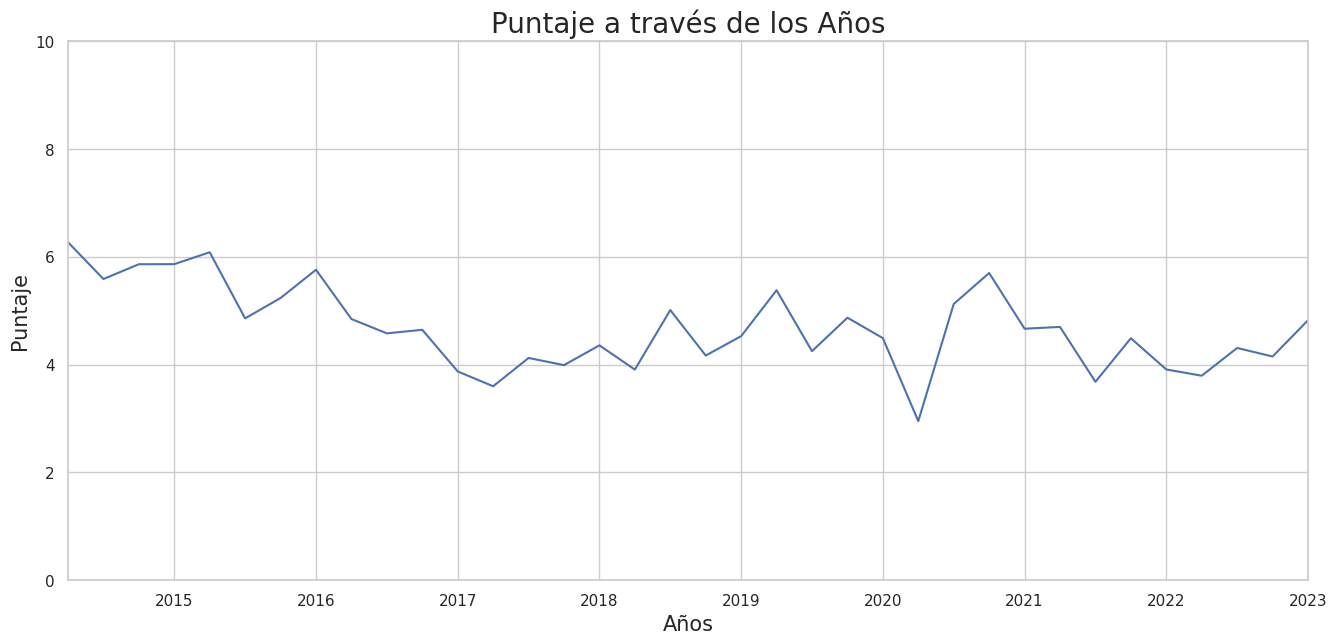

In [ ]:
visua1=cleanReviews.groupby(pd.PeriodIndex(cleanReviews['date'], freq='Q'))['rates'].mean()

plt.figure(figsize=(16, 7))

visua1.plot.line()

plt.title('Puntaje a través de los Años', fontsize=20)
plt.xlabel('Años',fontsize=15)
plt.ylabel('Puntaje',fontsize=15)

plt.ylim(0,10)
plt.show()

**ViolinPlot**

**2) ¿Cuáles fuerón las palabras que menor puntaje tienen?**

Para este punto analizaremos entre los años 2017 y 2020, decidimos elegir estos años por que en los años 2020 al 2022 la cantidad de review ha sido muy baja a diferencia del resto de los años. Por otro lado consideramos puntuaciones bajas las palabras menor a 4 puntos.

Sonaba tentador tomar las palabras con mayor frecuencia como seat, service,food,class entre otros, pero nos dimos cuenta que estas palabras no nos generaba información sobre el por que el cliente dió una puntuación baja, ya que en algunos casos los clientes indicaban que el servicio era bueno, es por ello decidimos ir por otras palabras que generan "palabras negativas" a la cia.

En cuanto a la experiencia, hemos visto que es muy variado, por que para algunos ha sido buena experiencia y a otros no

Hay una cantidad de clientes que consideran pobre la calidad de la comida, y la antiguedad de los asientos como lo poco amplio que són y se han quejado que los auriculares no son buenos ya que se filtra el ruido externo y se complica a la hora de ver una pelicula durante su vuelo

Por otro lado indican que debería mejorar la limpieza, si bien es una clase economica, no debería ser motivo para que la limpieza sea precaria.

En algunos casos a la hora del emabarque lo consideran desorganizado

También hubo quejas de vuelos atrasados y todas estas cosas hacen que baje la puntuación a la cia.






In [ ]:
# Tomamos el archivo cleanReviews por que consideramos todos los casos, reserva concretada y
# Consideramos menor puntaje a todas aquellas palabras menor a 4

analisis2 = cleanReviews[((cleanReviews['year'] > 2016) &  (cleanReviews['year'] < 2020)) & (cleanReviews['rates'] < 4)]

In [ ]:
#Ver luego de dejar este método arriba de todo, pq es algo que lo venimos usando en otros puntos y así ahorramos código repetido

# Cuenta la frecuencia de cada palabra
word_counter = Counter()
for tokens in analisis2['tokens']:
    word_counter.update(tokens)


In [ ]:
top_words = word_counter.most_common()

In [ ]:
# price, luggage,experience,choice,trip,never,problem,refund,terrible,unconfortable,
# boarding, lounge, experience, return, poor,luggage, never, delayed, carrier, problem, late, security, uncomfortable
top_words

[('flight', 1398),
 ('seat', 827),
 ('london', 630),
 ('service', 574),
 ('food', 439),
 ('airline', 418),
 ('airway', 413),
 ('british', 411),
 ('time', 396),
 ('crew', 389),
 ('class', 376),
 ('cabin', 355),
 ('good', 339),
 ('review', 332),
 ('heathrow', 325),
 ('business', 325),
 ('hour', 310),
 ('staff', 283),
 ('economy', 282),
 ('would', 279),
 ('meal', 247),
 ('check', 230),
 ('drink', 224),
 ('plane', 220),
 ('first', 215),
 ('customer', 214),
 ('passenger', 213),
 ('back', 210),
 ('even', 200),
 ('boarding', 187),
 ('lounge', 183),
 ('experience', 168),
 ('club', 168),
 ('like', 166),
 ('long', 164),
 ('could', 162),
 ('told', 160),
 ('return', 159),
 ('aircraft', 152),
 ('airport', 150),
 ('year', 150),
 ('cost', 146),
 ('premium', 144),
 ('minute', 144),
 ('take', 141),
 ('better', 141),
 ('well', 141),
 ('really', 135),
 ('served', 132),
 ('flying', 127),
 ('choice', 126),
 ('also', 125),
 ('poor', 124),
 ('board', 121),
 ('next', 121),
 ('asked', 120),
 ('great', 120),
 (

In [ ]:
#creamos un nuevo datafreme con las palabras mas relevantes de este anio
dftop_words=pd.DataFrame(top_words)

In [ ]:
dftop_words.columns=['words','frecuencia']
dftop_words

,words,frecuencia
0,flight,1398
1,seat,827
2,london,630
3,service,574
4,food,439
...,...,...
5487,astonishing,1
5488,hardworking,1
5489,salvage,1
5490,logo,1


In [ ]:
# Dejamos las palabras más relevantes, para posteriormente sacar su promedio en función del puntaje (rates)
# delayed, missed, cancel
listaDePalabras = {'experience','boarding','poor','terrible','delayed','never','luggage','refund'}
#listaDePalabras= {'check','customer','passenger','boarding','lounge','experience','long','return','year','cost','choice','poor','board'}
# price, luggage,experience,choice,trip,never,problem,refund,terrible,unconfortable,

# boarding, lounge, experience, return, poor,luggage, never, delayed, carrier, problem, late, security, uncomfortable

In [ ]:
analisis2['list_word'] = analisis2.apply(filter_dataframe, axis=1)

In [ ]:
# Nos quedamos solo con aquellas listas que no son vacias
datos2 = analisis2[analisis2['list_word'].map(len) > 0]

In [ ]:
# dejamos que cada elemento de una fila de list_word sea spliteado. asi nos queda una palabra por fil
datos3 = datos2.explode('list_word', ignore_index = True)[['rates','country','month','comments','list_word']]

In [ ]:
newdatos2 = datos3.drop_duplicates(['comments'], keep = 'first')
newdatos2.head()

,rates,country,month,comments,list_word
0,1,United Kingdom,12,copenhagen london super slow wait bus delayed ...,delayed
3,3,Vietnam,12,budapest billund return via london dec aircraf...,luggage
5,3,United Kingdom,12,sofia london good overall experience departure...,experience
11,1,United Kingdom,12,london glasgow british airway flight delayed l...,delayed
14,1,United Kingdom,12,johannesburg london recently refurbished first...,poor


In [ ]:
experience = newdatos2[newdatos2['list_word'] == 'experience']

for index, row in experience.iterrows():
   print(row['comments'])

sofia london good overall experience departure experience let poor airport lounge sofia complete failure honour priority boarding flight experience generally good arrival experience heathrow good efficient
london mauritius fortunate enough flown many different airline including low cost carrier also upper class cabin premium airline without shadow doubt whole british airway experience poorest aeroplane seat general service experience importantly poor customer service following bad flight truly feel airline deserves go bust truly disgraceful approach service product deliver begrudge flying given option always choose different airline
london heathrow lisbon mediocre flight smooth arrived time cabin service left great deal desired staff seemed going motion bread roll offered meal service despite requesting glass wine accompany meal forthcoming staff required nudge delivered great club europe experience
hyderabad san francisco via london awesome experience one customer service representati

In [ ]:
embarque = newdatos2[newdatos2['list_word'] == 'boarding']

for index, row in embarque.iterrows():
   print(row['comments'])

verified london johannesburg british airway ba b gate lounge rather civilised place pas time gallery lounge main terminal also tad closer transit via rather useful walkway level c gate depart new boarding group meant snaking queue least group moved fairly speedily club world still much maligned seat small unresponsive ife screen limited selection film dinner service slow unwise introduction individual tray brought seat trolley may lack glamour one get sleep quicker overnight flight breakfast adequate nothing landing exactly time overall reasonable flight inflight service distinctly average
london cape town booked business class ticket year advance trip africa usually fly star alliance picked ba segment better connection timing london cape town huge mistake tried reserve seat ba website twice able tried call ba twice gave hold hour time call back option arrived today london toronto connection desk seven hour flight told business class oversold would downgraded premium economy ba represe

In [ ]:
poor = newdatos2[newdatos2['list_word'] == 'poor']

for index, row in poor.iterrows():
   print(row['comments'])

johannesburg london recently refurbished first club world lounge jnb failed resolve congestion passenger two evening flight lhr descend table space eating food improved poor acoustic mean intrusion privacy cry baby facetime call add restless maelstrom human activity boarding reasonably quick although usual confusion group queue predominantly young mixed fleet crew competent lacked finesse kept getting drink order muddled meal service took age unidentified problem heating main course food bad finally served cabin temperature hot slept quite well arrival ten minute ahead schedule baggage collection quick overall good flight despite aged club world product
london shanghai disappointing business class flown long time plane old worn dirty crumb food seat floor previous flight took hour drink service reach seat take food followed shortly cooked seemed short staff however made really angry people cabin drink food bed turned even offered drink service exceptionally poor flying home tomorrow lo

In [ ]:
terrible = newdatos2[newdatos2['list_word'] == 'terrible']

for index, row in terrible.iterrows():
   print(row['comments'])

london san francisco return economy seat small outbound bearable empty seat two u returning empty seat horrible female lean seat front collect belonging want get anything bag seat front need major maneuvering touching person next throughout flight unavoidable flew way longer air vent adjust flight got stuffy warm ask turn c way literally sweating economy small aircraft mostly made business class asian vegetarian meal good usual although breakfast terrible asian vegetarian breakfast economy plus much better find alternative airline long haul flight worth
verified terrible lack leg body room economy easily cramped space ever flown travel lot flight hour leg cramp pain room modicum comfort little amount space economy cabin disgusting seat front reclines invariably even le room shameful food average well even bottom barrel budget airplane food never fly british airway star beware add nyc jfk london waiting area near enough seat requiring many stand sit floor call plane disorganized bedlam 

In [ ]:
demorado = newdatos2[newdatos2['list_word'] == 'delayed']

for index, row in demorado.iterrows():
   print(row['comments'])

copenhagen london super slow wait bus delayed also packed bus tight people far arrival terminal service bad staff coming terminal worst terminal heathrow food beverage board terrible price price airline ticket whole experience way expected service time staff
london glasgow british airway flight delayed like one delayed every week like bad joke really poor yet expensive airline recommend traveller
london bangalore flight bangalore london november delayed hour resulted missing connection flight return london bangalore initially delayed hr assigned boarding gate waiting gate min announcement made flight delayed hr min due maintenance
johannesburg amsterdam via london many delayed departure announced flight cancelled rescheduled depart following night pm following night pm announced delay due technical fault reported hour previously finally departed pm consequence missed connecting flight amsterdam also pay show hotel amsterdam trying claim charge ba declined offered pay taxi arrived amste

In [ ]:
palabrasConPuntaje = newdatos2.groupby('list_word').agg({'rates': ['min', 'max', 'mean', 'count']}).stack()
palabrasConPuntaje


rates
list_word                            
boarding   min                   1.00
           max                   3.00
           mean                  1.71
           count               102.00
delayed    min                   1.00
           max                   3.00
           mean                  1.80
           count                54.00
experience min                   1.00
           max                   3.00
           mean                  1.79
           count                89.00
luggage    min                   1.00
           max                   3.00
           mean                  1.83
           count                30.00
never      min                   1.00
           max                   3.00
           mean                  1.67
           count                43.00
poor       min                   1.00
           max                   3.00
           mean                  1.73
           count                49.00
refund     min                   1.00
           max                   3.00
           mean                  1.95
           count                19.00
terrible   min                   1.00
           max                   3.00
           mean                  1.80
           count                20.00

[Text(0, 0, 'delayed'),
 Text(1, 0, 'luggage'),
 Text(2, 0, 'experience'),
 Text(3, 0, 'poor'),
 Text(4, 0, 'never'),
 Text(5, 0, 'boarding'),
 Text(6, 0, 'terrible'),
 Text(7, 0, 'refund')]

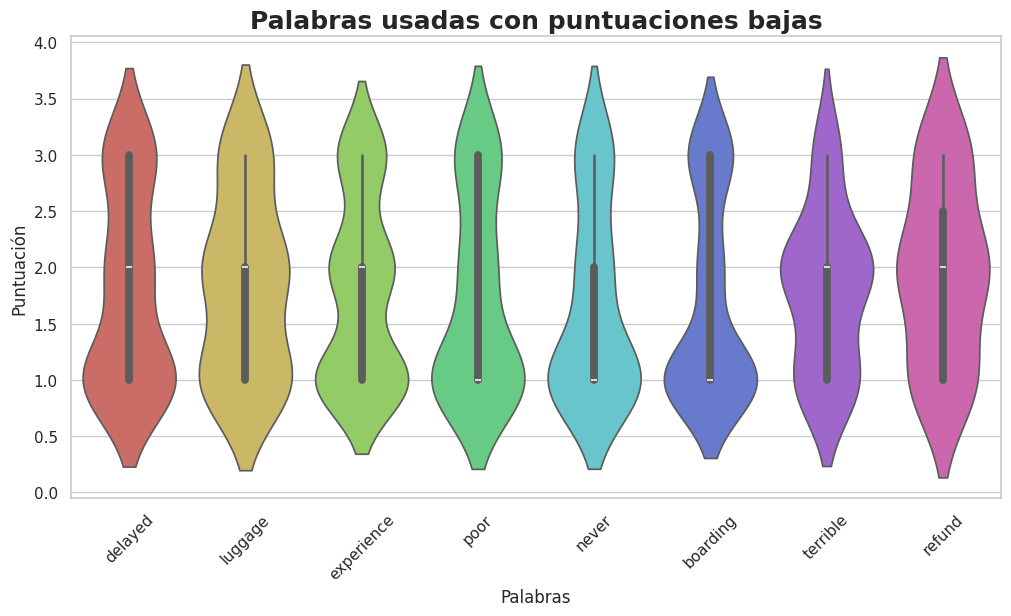

In [ ]:
plt.figure(figsize=(12, 6))

violinPlot = sns.violinplot(data = newdatos2, x="list_word", y="rates", hue="list_word", legend = False , palette = "hls")

violinPlot.set_title("Palabras usadas con puntuaciones bajas", fontsize=18, fontweight= 'heavy')
violinPlot.set_xlabel("Palabras")
violinPlot.set_ylabel("Puntuación")
violinPlot.set_xticklabels(violinPlot.get_xticklabels(), rotation=45)

**Scatter plot**

**3) ¿Porqué en entre los años 2020 y 2022 la empresa tiene pocos reviews?**  

Sucedió la etapa del covid, por lo que los clientes indican que le cancelaron los vuelos, quejandose de la parte de atención al cliente ya que cuando solicitaban su reembolso tardarón y en algunos casos no le daban una explicación a sus vuelos cancelados. Por otro lado, en algunos casos le dieron unos voucher pero los clientes solicitaban el reembolso, ya que en esos años era complicado viajar.
Los vuelos que si salieron, no fueron a horario, por lo que indican que eran vuelos atrasados

In [ ]:
analisis3 = cleanReviews[(cleanReviews['year'] > 2019) & (cleanReviews['year'] < 2023)]

In [ ]:
word_counter = Counter()
for tokens in analisis3['tokens']:
    word_counter.update(tokens)

In [ ]:
palabras = word_counter.most_common(60)

In [ ]:
top_words=pd.DataFrame(palabras)

In [ ]:
top_words.columns=['words','frecuencia']
top_words

,words,frecuencia
0,flight,874
1,seat,299
2,service,297
3,time,267
4,hour,237
5,food,190
6,good,180
7,london,179
8,airline,174
9,crew,173


In [ ]:
listaDePalabras = {'cancelled','experience','voucher','boarding','refund','covid'}

In [ ]:
analisis3['list_word'] = analisis3.apply(filter_dataframe, axis=1)

In [ ]:
datos3 = analisis3[analisis3['list_word'].map(len) > 0]

In [ ]:
newdatos3 = datos3.explode('list_word', ignore_index = True)[['rates','comments','list_word']]

In [ ]:
finaldatos3 = newdatos3.drop_duplicates(['comments'], keep = 'first')
finaldatos3.head()

,rates,comments,list_word
0,3,absolutely terrible experience british airway ...,experience
1,1,ancouver delhi via london booked fly vancouver...,refund
9,8,another ba shamble started well excellent chec...,boarding
10,3,verified ba cancelled flight home heathrow dec...,cancelled
13,1,verified ba cancelled flight home last flight ...,cancelled


In [ ]:
voucher = finaldatos3[finaldatos3['list_word'] == 'voucher']

for index, row in voucher.iterrows():
   print(row['comments'])

urned hour advance terminal london heathrow already carnage people trying check desk manned long queue security due line open people stressed pushing shouting flight delayed hour according pilot delay due suitcase needing loaded missed connecting flight doha hour wait til next one received voucher approx whole day arrived day later suitcase arrive filed claim desk day update information offer compensation solution offer spoilt holiday many personal belonging gone xmas gift missing extensive expense know reimbursed beware ba expect low level zero customer service old plane zero help anything go wrong missing personally avoid ba future cost
verified review ba booking system flight today clicked wrong date line mistake expect pay fee go cancel booking click option receive voucher immediately received response saying voucher way call speak gentleman continuously spoke would listen concern eventually give want book new flight obviously much higher price using voucher want however surprise u

In [ ]:
cancelar = finaldatos3[finaldatos3['list_word'] == 'cancelled']

for index, row in cancelar.iterrows():
   print(row['comments'])

verified ba cancelled flight home heathrow dec th face sensible weather iceland appalling however acceptable flight cancelled hour take time time already struggling dreadful driving condition get airport got nowhere near condition became bad taken advice would spared everyone need try travel road ended closed booked onto flight st downgraded sin checked today type cancelled flight th despite road keflav k closed check thing help ba offered really
verified ba cancelled flight home last flight day heathrow tried push onto another flight london city hour later car heathrow want try cross london late night public transport luggage especially rail strike announced around time book flight home lufthansa cost economy seat least got home heathrow another terminal friday night could get home family still news refund month shame flying ba used pleasurable experience ba cancelled moved one leg every journey booked year regrettably use airline much better reliability customer service
verified gene

In [ ]:
reembolso = finaldatos3[finaldatos3['list_word'] == 'refund']

for index, row in reembolso.iterrows():
   print(row['comments'])

ancouver delhi via london booked fly vancouver new delhi via london heathrow dec nd received email dec th informing u industrial action uk called find may impact travel representative kind scared u possibly stranded travel offered u full refund called confirm option offer solution asked cancel ticket told u cancellation fee booked new ticket another airline double cost trip urgent simultaneously told u longer cancel ticket system promised u make happen told u would get full refund processed cancellation hour later emailed u ticket cancelled suggested cancel new ticket found another airline lost cancelling new ticket representative claimed never said service available asked u worrying industrial action arrangement made issue new information never given u kept british airway ticket next day asked speak manager report misguided whole situation never heard back manager logged check hour take found van lhr flight cancelled due bad weather vancouver receive email airport airline change calle

In [ ]:
covid = finaldatos3[finaldatos3['list_word'] == 'covid']

for index, row in covid.iterrows():
   print(row['comments'])

told require hr negative covid test entry philippine booked trip via ba com transfer singapore delay transfer next day okay bothered hr negative covid test try check changi airport philippine airline check staff require hr negative covid test rush different terminal get tested wait result rush back check gate closed book extra night singapore hotel book flight manila also return journey back london one miss one leg ba booked flight remaining flight get cancelled discovered oman air business class better british airway treating customer quality service business class experience
new route ba introduced beginning june several year covid related delay business class experience fear typical nickel dime policy introduced airline past decade plus helpful friendly fa minus cabin fairly cramped six seat across pod surprisingly little room limited storage space hard adjust seat particularly getting lie flat even fa found difficult flight entertainment limited poor choice film tv programme music 

In [ ]:
palabrasConPuntaje = finaldatos3.groupby('list_word').agg({'rates': ['min', 'max', 'mean', 'count']}).stack()
palabrasConPuntaje

rates
list_word                            
boarding   min                   1.00
           max                  10.00
           mean                  4.54
           count                54.00
cancelled  min                   1.00
           max                  10.00
           mean                  3.44
           count                48.00
covid      min                   1.00
           max                  10.00
           mean                  3.73
           count                30.00
experience min                   1.00
           max                  10.00
           mean                  3.84
           count                55.00
refund     min                   1.00
           max                  10.00
           mean                  2.92
           count                24.00
voucher    min                   1.00
           max                  10.00
           mean                  4.23
           count                13.00

[Text(0, 0, 'experience'),
 Text(1, 0, 'refund'),
 Text(2, 0, 'boarding'),
 Text(3, 0, 'cancelled'),
 Text(4, 0, 'voucher'),
 Text(5, 0, 'covid')]

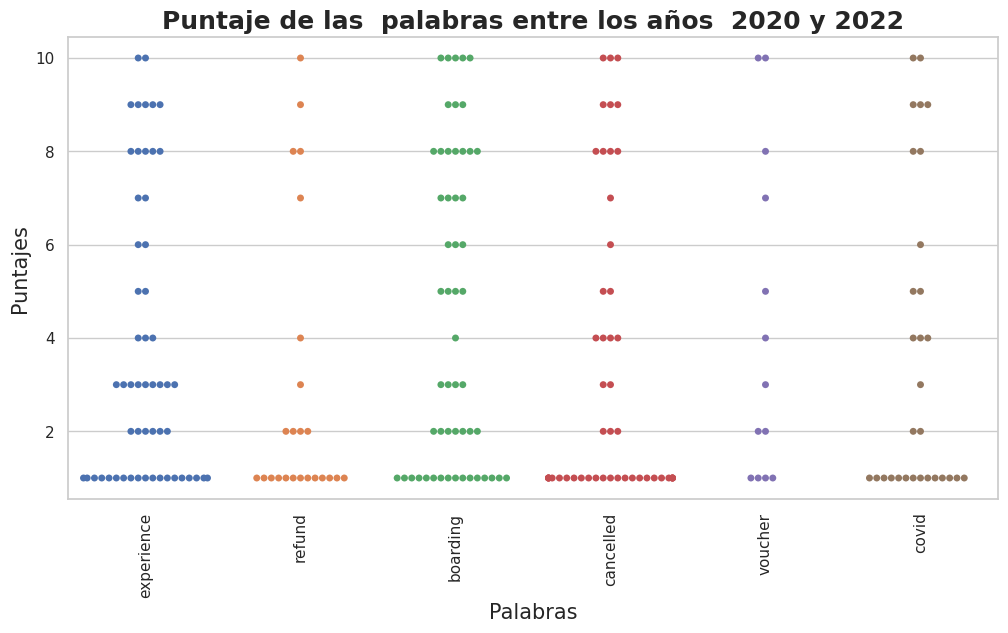

In [ ]:
plt.figure(figsize=(12, 6))

visuaSwarmplot = sns.swarmplot(data = finaldatos3, x="list_word", y="rates", hue="list_word", legend=False)

visuaSwarmplot.set_title("Puntaje de las  palabras entre los años  2020 y 2022", fontsize=18, fontweight= 'heavy')
visuaSwarmplot.set_xlabel("Palabras",fontsize=15)
visuaSwarmplot.set_ylabel("Puntajes",fontsize=15)
visuaSwarmplot.set_xticklabels(visuaSwarmplot.get_xticklabels(), rotation=90)

**Grouped Bar plot**

**4) ¿Cúal es la puntuación promedio que obtuvo el servicio de asientos preferenciales y comida a lo largo del tiempo?**  

Para este punto usamos el archivo merged y consideramos las reservas concretadas. Por otro lado consideramos que la cantidad de datos aportados en los años 2014 y 2018 es muy menor para analizar sus datos a comparación del resto, es por ello que considaremos en esta parte el análisis los años comprendidos mayor a 2018.

Por la visualización podemos observar que en el año 2020 la empresa ha recibido un promedio de puntuación muy elevada al resto de los años



In [ ]:
seleccion4 = merged[(merged['booking_complete'] == 1)][['year','wants_preferred_seat','wants_in_flight_meals','rates']]

In [ ]:
seleccion4.year.value_counts()

year
2022    3846
2019    1983
2017     625
2020     605
2023     107
2021      76
2018      12
2014       3
Name: count, dtype: int64

In [ ]:
# Consideramos los años mayores a 2018, ya que la cantidad de reseña es muy menor a diferencia de los otros años
seleccion4 = seleccion4[seleccion4['year'] > 2018]

In [ ]:
seleccion4['promedio_asiento_preferencial'] = seleccion4.groupby(['year','wants_preferred_seat'])['rates'].transform(lambda x: x.mean())
seleccion4['promedio_servicio_comida'] = seleccion4.groupby(['year','wants_in_flight_meals'])['rates'].transform(lambda x: x.mean())

In [ ]:
promAsientoPref = seleccion4[seleccion4['wants_preferred_seat'] == 1]
promServCom = seleccion4[seleccion4['wants_in_flight_meals'] == 1]

In [ ]:
asientoPref = promAsientoPref.groupby(['year','promedio_asiento_preferencial'])['wants_preferred_seat'].count()
asientoPref

year  promedio_asiento_preferencial
2019  1.98                              597
2020  9.45                              249
2021  1.19                               42
2022  3.95                             1433
2023  2.63                               38
Name: wants_preferred_seat, dtype: int64

In [ ]:
comidaPref = promServCom.groupby(['year','promedio_servicio_comida'])['wants_in_flight_meals'].count()
comidaPref

year  promedio_servicio_comida
2019  2.01                         807
2020  9.28                         261
2021  1.19                          43
2022  4.02                        1886
2023  2.65                          46
Name: wants_in_flight_meals, dtype: int64

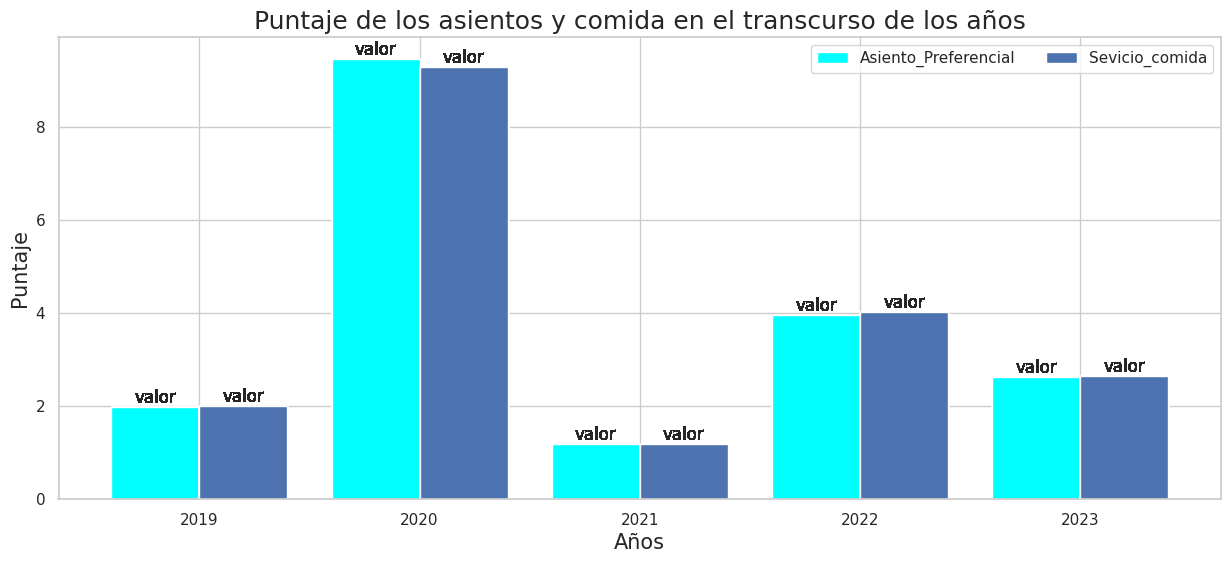

In [ ]:
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(111)

width = 0.40

rect1 = plt.bar(promAsientoPref['year']-0.2,promAsientoPref['promedio_asiento_preferencial'] , width, color='cyan')
rect2 = plt.bar(promServCom['year']+0.2, promServCom['promedio_servicio_comida'], width)
plt.legend(['Asiento_Preferencial','Sevicio_comida'], loc='upper right', ncols=2)
plt.xlabel('Años', fontsize = 15)
plt.ylabel('Puntaje', fontsize=15)
plt.title('Puntaje de los asientos y comida en el transcurso de los años',fontsize=18)

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.00*h, 'valor', ha='center', va='bottom')


autolabel(rect1)
autolabel(rect2)

**LinePlot**

**5) ¿Cómo fue la evolución de los servicios: comida, asiento, service, staff, entretenimiento y cabina a través de los años?**

En esta parte de la visualización decidimos tomar los años 2014 y2019

A traves de la visualización 5, podemos ver que en el año 21014 tuvo un alto puntaje, se puede ver también que a través de los años, la cia ha tenido un bajo puntaje en cuanto a la comida y los asientos, respecto al personal de cabina, en todos los años tiene mayor puntaje

In [ ]:
archivo5 = cleanReviews

In [ ]:
# Cuenta la frecuencia de cada palabra
palabraMasUsadas = Counter()
for tokens in cleanReviews['tokens']:
    palabraMasUsadas.update(tokens)

topMasUsadas= palabraMasUsadas.most_common(80)

In [ ]:
topMasUsadas

[('flight', 7198),
 ('seat', 4208),
 ('service', 2762),
 ('time', 2262),
 ('food', 2248),
 ('london', 2123),
 ('crew', 2080),
 ('british', 2012),
 ('airway', 2004),
 ('good', 1981),
 ('cabin', 1960),
 ('class', 1823),
 ('hour', 1698),
 ('airline', 1611),
 ('business', 1484),
 ('staff', 1464),
 ('heathrow', 1442),
 ('would', 1399),
 ('economy', 1342),
 ('passenger', 1224),
 ('first', 1212),
 ('check', 1199),
 ('drink', 1162),
 ('meal', 1106),
 ('plane', 1093),
 ('lounge', 1054),
 ('return', 1049),
 ('club', 1042),
 ('back', 996),
 ('boarding', 937),
 ('review', 937),
 ('experience', 898),
 ('even', 885),
 ('could', 879),
 ('customer', 836),
 ('aircraft', 819),
 ('minute', 734),
 ('like', 731),
 ('long', 697),
 ('told', 696),
 ('well', 675),
 ('really', 666),
 ('better', 663),
 ('comfortable', 650),
 ('world', 634),
 ('choice', 634),
 ('much', 632),
 ('year', 626),
 ('airport', 626),
 ('served', 624),
 ('premium', 624),
 ('great', 622),
 ('flew', 603),
 ('poor', 599),
 ('also', 590),
 ('

In [ ]:
# Dejamos las palabras más relevantes, para posteriormente sacar su promedio en función del puntaje (rates)
listaDePalabras= {'seat','food','service','staff','entertainment','cabin'}

In [ ]:
archivo5['list_word'] = archivo5.apply(filter_dataframe, axis=1)

In [ ]:
# Nos quedamos solo con aquellas listas que no son vacias
newdf5 = archivo5[archivo5['list_word'].map(len) > 0]

In [ ]:
# dejamos que cada elemento de una fila de list_word sea spliteado. asi nos queda una palabra por fil
datos5 = newdf5.explode('list_word', ignore_index = True)


In [ ]:
finaldatos5 = datos5.drop_duplicates(['comments'], keep = 'first')

In [ ]:
finaldatos5['newdate'] = pd.PeriodIndex(finaldatos5['date'], freq='Q').strftime('%m-%Y')

In [ ]:
paraVisua5 = finaldatos5[(finaldatos5['year'] < 2020) & (finaldatos5['year'] > 2013)]

In [ ]:
tabla5bis = paraVisua5.groupby(['year','list_word'])['rates'].mean()

In [ ]:
plt.figure(figsize=(15, 7))

visua5 = sns.lineplot(data=paraVisua5, x='newdate', y='rates', hue='list_word', errorbar=None, style = 'list_word', markers=True)

visua5.set_title('Puntaje de los servicios en el transcurso del tiempo', fontsize=18, fontweight = 'heavy')
visua5.set_xlabel('Mes-Año', fontsize=18)
visua5.set_ylabel('Puntaje', fontsize=18)
visua5.set_xticklabels(visua5.get_xticklabels(), rotation=90)


#plt.ylim(0,10)
#plt.xlim(06-2014,12-2019)
#plt.xlim(pd.Timestamp('2014-03-01'), pd.Timestamp('2019-12-01'))
#plt.xlim([datetime.date('2014-06-01'), datetime.date('2019-12-01')])
visua5.invert_xaxis()
plt.show()

NameError: name 'plt' is not defined

*Estas 2 lineas de código no lo usamos*

In [ ]:
#Buscamos el valor que tiene esa palabra respecto a rates y devolvemos la puntuación

def find_rates_words(row, word):
    word_list = row['tokens']
    numbers = row['rates']

    if word in word_list:
        return numbers
    else:
        return 0

In [ ]:
archivo5['rates_service'] = archivo5.apply(lambda row: find_rates_words(row, 'service'), axis=1)
archivo5['rates_staff'] = archivo5.apply(lambda row: find_rates_words(row, 'staff'), axis=1)
archivo5['rates_seat'] = archivo5.apply(lambda row: find_rates_words(row, 'seat'), axis=1)
archivo5['rates_time'] = archivo5.apply(lambda row: find_rates_words(row, 'time'), axis=1)
archivo5['rates_food'] = archivo5.apply(lambda row: find_rates_words(row, 'food'), axis=1)
archivo5['rates_cabin'] = archivo5.apply(lambda row: find_rates_words(row, 'cabin'), axis=1)
archivo5['rates_economy'] = archivo5.apply(lambda row: find_rates_words(row, 'economy'), axis=1)

**Esta línea lo usamos para la visua original**

In [ ]:
paraVisuaOriginal = finaldatos5.groupby(['year','list_word'])['rates'].mean()
paraVisuaOriginal

year  list_word    
2014  cabin                           5.87
      entertainment                   5.50
      food                            5.70
      seat                            5.89
      service                         5.98
      staff                           6.33
2015  cabin                           5.74
      entertainment                   5.11
      food                            5.44
      seat                            5.19
      service                         5.57
      staff                           5.62
2016  cabin                           5.19
      entertainment                   6.25
      food                            5.11
      seat                            4.86
      service                         4.59
      staff                           5.18
2017  cabin                           4.56
      entertainment                   5.00
      food                            3.55
      seat                            3.78
      service                     

**6. ¿Cual es el canal de venta con más reservas concretadas**

Vemos que los clientes optan usar internet para las reservas concretadas.
Esto es interesante, ya que la empresa puede reforzar su publicidad a través de las redes y no perder ese público que es el que genera más ventas

In [ ]:
analisisPorCanal= merged[merged['booking_complete']==1][['sales_channel','year','booking_complete']]

In [ ]:
grupo = analisisPorCanal.groupby(['year','sales_channel']).sum().reset_index()
grupo = grupo.rename(columns={'booking_complete':'cantidad'})

In [ ]:
total = grupo['cantidad'].sum()
total

7257

In [ ]:
grupo['porcentaje'] = (grupo['cantidad']/total)*100
grupo

,year,sales_channel,cantidad,porcentaje
0,2014,Internet,3,0.04
1,2017,Internet,548,7.55
2,2017,Mobile,77,1.06
3,2018,Internet,12,0.17
4,2019,Internet,1840,25.35
5,2019,Mobile,143,1.97
6,2020,Internet,519,7.15
7,2020,Mobile,86,1.19
8,2021,Internet,68,0.94
9,2021,Mobile,8,0.11


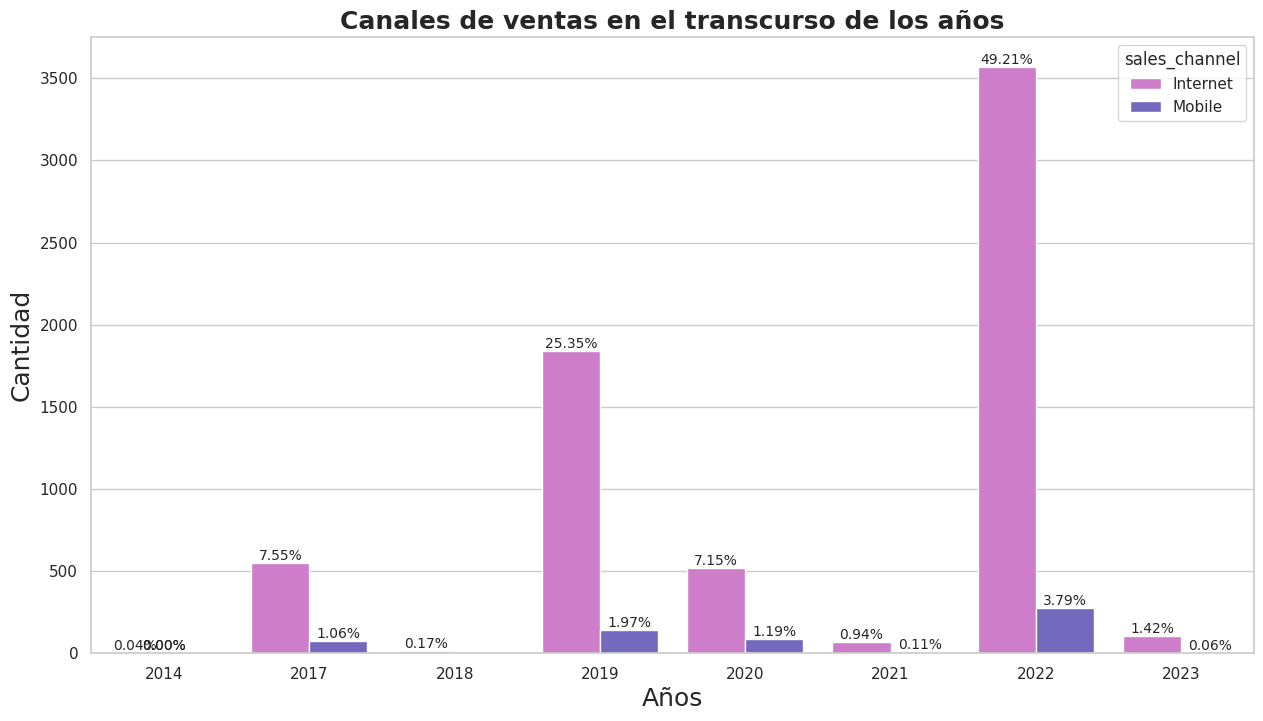

In [ ]:
plt.figure(figsize=(15, 8))

ax= sns.barplot(x = 'year', y = 'cantidad', data=grupo, hue='sales_channel', palette=['orchid','slateblue'])

plt.title('Canales de ventas en el transcurso de los años',fontsize=18, fontweight = 'heavy')
plt.xlabel('Años', fontsize=18)
plt.ylabel('Cantidad', fontsize=18)

#for container in visua7.containers:
   #visua7.bar_label(container,fmt='%.2f')

for p in ax.patches:
    porcentaje = '{:.2f}%'.format(100 * p.get_height() / total)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(porcentaje, (x, y), ha='center', va='bottom', fontsize=10)

plt.show()

**Heatmap**

**7) ¿Cual es el promedio de las personas que viajan en la cia en el transcurso del tiempo?**

Para este punto usamos el merged, ya que consideramos que las personas que realizaron algun comentario es por que han clasificado segun la experiencia de su viaje en nuestra cia. Así como las reservas no caidas. Ya que una reserva caida puede ser por parte de la cia y el cliente nos puede dejar un comentario negativo a ello. Pero no es indicador de que haya volado con la cia.

Vemos por la visualización 8 que ha el boom de personas que viejaron fue en Noviembre del 2022, coincidencia con "liberación de pandemia"

En el próximo gráfico analizaremos de pais son procedentes estos clientes

In [ ]:
reservaNoCaida = merged[merged['booking_complete'] == 1 ]

In [ ]:
analisis7 = reservaNoCaida.groupby(['year','month']).agg({'num_passengers' : 'sum'}).unstack(fill_value=0)
analisis7.columns = analisis7.columns.droplevel(0)
analisis7

month,1,2,3,4,5,6,7,8,9,11,12
year,,,,,,,,,,,
2014,0,0,0,0,0,6,0,0,0,0,0
2017,0,0,0,0,1018,15,0,0,0,0,0
2018,0,0,1,0,0,0,0,0,0,18,0
2019,0,885,0,0,3,7,0,1744,684,1,146
2020,220,2,0,0,0,0,0,878,0,0,0
2021,0,0,0,1,0,0,116,0,0,0,0
2022,0,1,0,5,4,106,0,0,1681,4234,97
2023,155,0,0,0,0,0,0,0,0,0,0


<Axes: title={'center': 'Cantidad de Pasajeros que viajaron en la cia'}, xlabel='month', ylabel='year'>

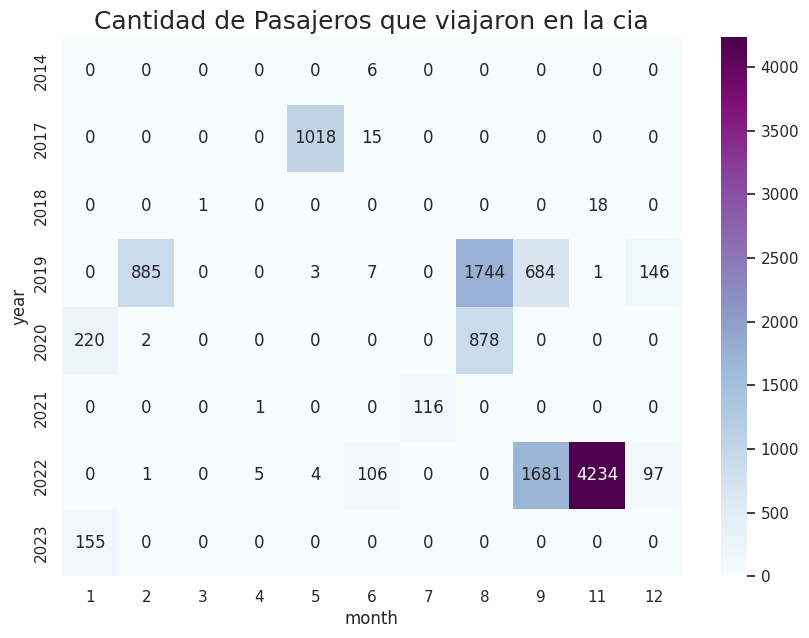

In [ ]:
fig,axes=plt.subplots(figsize=(10,7))

visuaheatmap = sns.heatmap(analisis7, cmap = 'BuPu', annot = True, fmt = 'd')

visuaheatmap.set_title('Cantidad de Pasajeros que viajaron en la cia', fontsize=18)
visuaheatmap

**Bar Plot con banderas**

**8) En el año Noviembre 2022 hubo el gran boom de venta de pasajes, a continuación realizaremos  que paises son estos clientes**

Los clientes que más compraron en el 2022 son de Malasia, seguido de China y Australia

In [ ]:
#vamos tomar solo los valores del mes de nov del año 2022
analisis=merged[(merged['year']==2022) & (merged['month'] == 11) & (merged['booking_complete']==1)]

In [ ]:
df_paises=analisis.groupby('country')['num_passengers'].sum()

In [ ]:
#vamos hacer el caso mas general ver todos los paises con sus respectivas cantidad de pasajeros de reservaNoCaida
sumaPasajerosPorPais=reservaNoCaida.groupby('country')['num_passengers'].sum().reset_index()

In [ ]:
sumaPasajerosPorPais.sort_values(['num_passengers'],ascending=False).head(10)

In [ ]:
import geopandas as gpd
#me voy a descargar el siguiente df, que nos aportara datos para poder mapear
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [ ]:
#solo vamos a tomar las columnas name y geomtry con la cual esto nos ayudara para hacer el grafico
datosParaGradicar=world[['name','geometry']]

In [ ]:
#hacemos el merge de los datafrime de datosParaGrafi y reservasNNoCaidas
mapeoPaises=sumaPasajerosPorPais.merge(datosParaGradicar, how='right',right_on='name',left_on='country').fillna(0)
gdf = gpd.GeoDataFrame(mapeoPaises)

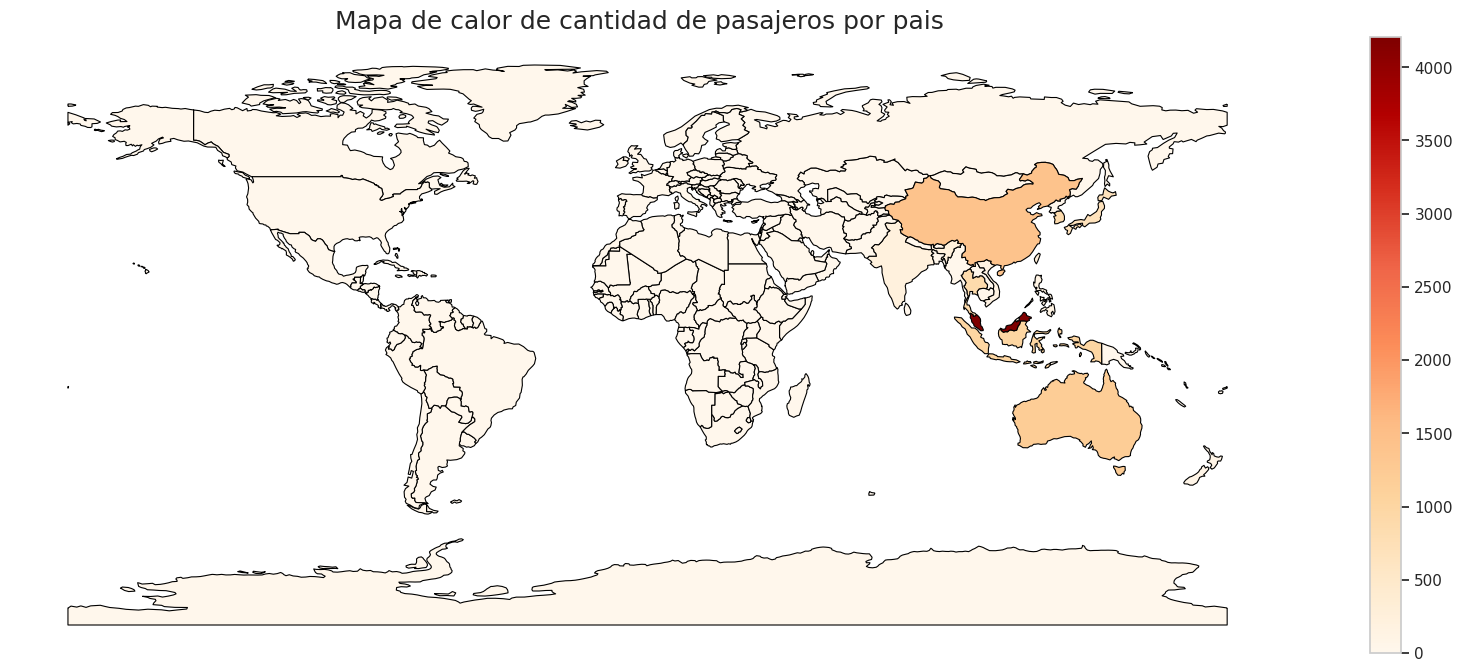

In [ ]:
# Graficamos utilizando GeoPandas
fig, ax = plt.subplots(1,1,figsize  = (22, 8))

gdf.plot(column='num_passengers',figsize=(12, 9),cmap='OrRd', linewidth=0.8,edgecolor='black',legend=True,ax=ax)
ax.set_title("Mapa de calor de cantidad de pasajeros por pais  ", fontsize=18)
ax.set_axis_off()

**BoxPlot**

**9) ¿Cúal es el promedio de dias que los clientes reservan los pasajes?**

Se puede ver que los clientes suelen reservar con anticipación sus pasajes entre 2 a 3 meses antes de su fecha de vuelo

In [ ]:
analisis10 = customer[customer['booking_complete'] == 1]

In [ ]:
promedioDiasDeReserva = analisis10.groupby('trip_type').agg({'purchase_lead': ['min', 'max', 'mean', 'sum']}).stack()
promedioDiasDeReserva

purchase_lead
trip_type                           
CircleTrip min                 35.00
           max                206.00
           mean               109.00
           sum                545.00
OneWay     min                  1.00
           max                299.00
           mean                66.00
           sum              1,320.00
RoundTrip  min                  0.00
           max                867.00
           mean                80.22
           sum            596,757.00

Text(0, 0.5, 'Cantidad de dias')

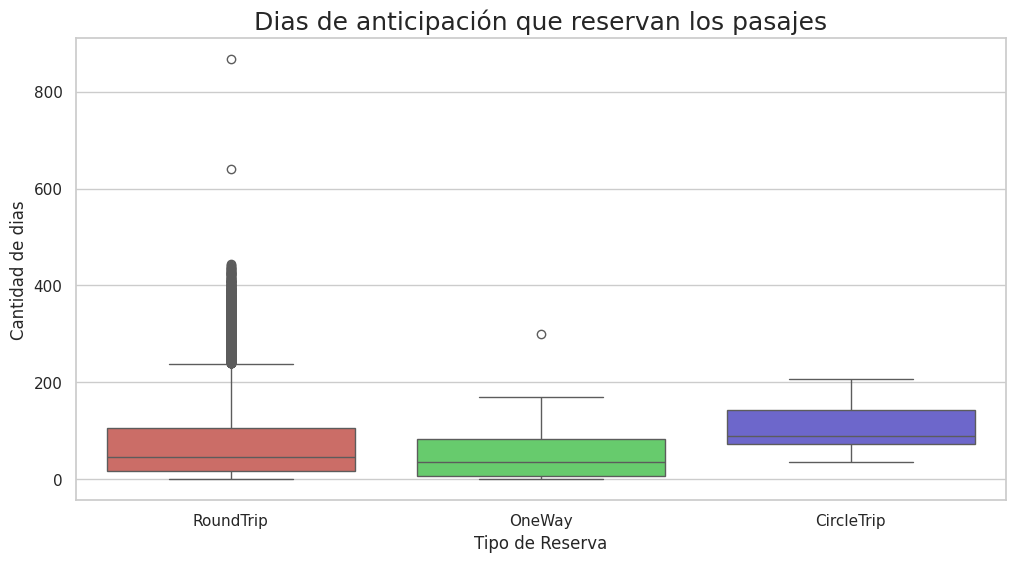

In [ ]:
plt.figure(figsize=(12, 6))

boxplot1 = sns.boxplot(x='trip_type', y='purchase_lead', data=analisis10, palette="hls")
boxplot1.set_title("Dias de anticipación que reservan los pasajes", fontsize=18)
boxplot1.set_xlabel("Tipo de Reserva")
boxplot1.set_ylabel("Cantidad de dias")

**10) ¿Con cuantos dias de anticipación cancelan la fecha de viaje?**

In [ ]:
analisis10 = customer[(customer['booking_complete']==0) & ((customer['purchase_lead']>0) & (customer['purchase_lead']<=180))][['trip_type','purchase_lead','booking_complete']]

In [ ]:
promedioReservaCaida = analisis10.groupby('trip_type').agg({'purchase_lead': ['min', 'max', 'mean', 'count']}).stack()
promedioReservaCaida

purchase_lead
trip_type                            
CircleTrip min                   5.00
           max                 179.00
           mean                 60.18
           count                91.00
OneWay     min                   1.00
           max                 172.00
           mean                 59.33
           count               302.00
RoundTrip  min                   1.00
           max                 180.00
           mean                 54.83
           count            35,546.00

In [ ]:
tabla=analisis10.groupby(['trip_type','purchase_lead'])['booking_complete'].count().reset_index()
newtabla = tabla.rename(columns = {'booking_complete':'cantidad'})

In [ ]:
newtabla

,trip_type,purchase_lead,cantidad
0,CircleTrip,5,1
1,CircleTrip,6,1
2,CircleTrip,7,1
3,CircleTrip,9,1
4,CircleTrip,10,2
...,...,...,...
365,RoundTrip,176,37
366,RoundTrip,177,57
367,RoundTrip,178,57
368,RoundTrip,179,57


([<matplotlib.axis.YTick at 0x7b69047fe920>,
 [Text(0, 0, '0'),
  Text(0, 50, '50'),
  Text(0, 100, '100'),
  Text(0, 150, '150'),
  Text(0, 200, '200'),
  Text(0, 250, '250'),
  Text(0, 300, '300'),
  Text(0, 350, '350'),
  Text(0, 400, '400'),
  Text(0, 450, '450'),
  Text(0, 500, '500'),
  Text(0, 550, '550')])

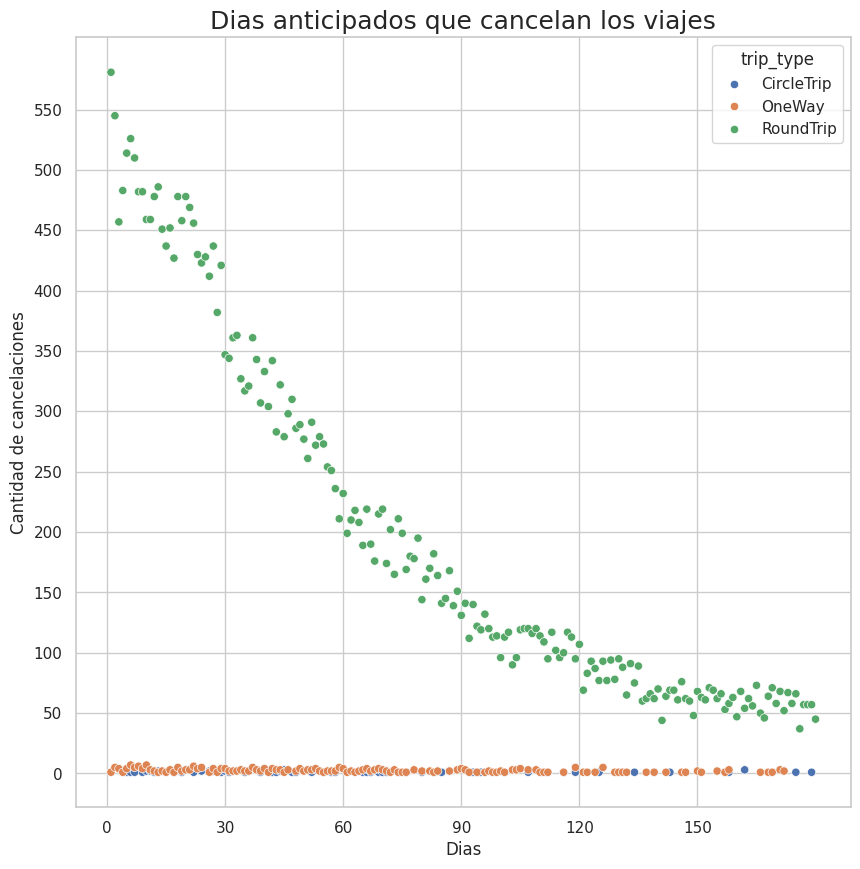

In [ ]:
plt.figure(figsize=(10, 10))

visua11 = sns.scatterplot(data=newtabla, x="purchase_lead", y="cantidad", hue="trip_type")
visua11.set_title("Dias anticipados que cancelan los viajes", fontsize=18)
visua11.set_xlabel("Dias")
visua11.set_ylabel("Cantidad de cancelaciones")

plt.xticks(np.arange(0, 180, 30))
plt.yticks(np.arange(0, 600, 50))

**11) ¿Por que se caen las reservas? ¿ fue por parte de la cia o de los clientes ?**

**12) Visualización original**

In [ ]:
pip install kaleido

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 9.5 MB/s eta 0:00:00


**Copio acá por si pierdo las lineas del codigo en el proyecto nuevo, ya que no me guarda algunos cambios**

In [ ]:

import plotly.graph_objects as go
from plotly.subplots import make_subplots
from PIL import Image, ImageDraw
import os
from PIL import Image

In [ ]:
paraVisuaOriginal

year  list_word    
2014  cabin                           5.87
      entertainment                   5.50
      food                            5.70
      seat                            5.89
      service                         5.98
      staff                           6.33
2015  cabin                           5.74
      entertainment                   5.11
      food                            5.44
      seat                            5.19
      service                         5.57
      staff                           5.62
2016  cabin                           5.19
      entertainment                   6.25
      food                            5.11
      seat                            4.86
      service                         4.59
      staff                           5.18
2017  cabin                           4.56
      entertainment                   5.00
      food                            3.55
      seat                            3.78
      service                     

In [ ]:
promedio=paraVisuaOriginal.unstack()

In [ ]:
promedio

list_word,cabin,entertainment,food,seat,service,staff
year,,,,,,
2014,5.87,5.50,5.70,5.89,5.98,6.33
2015,5.74,5.11,5.44,5.19,5.57,5.62
2016,5.19,6.25,5.11,4.86,4.59,5.18
2017,4.56,5.00,3.55,3.78,3.79,3.69
2018,4.61,5.33,4.47,4.06,4.34,4.62
2019,4.58,4.29,5.05,4.80,5.21,4.66
2020,5.44,4.25,3.73,3.81,4.12,6.13
2021,3.64,5.00,4.22,5.54,4.36,4.00
2022,4.67,10.00,3.52,3.50,4.24,4.22


In [ ]:
promedio.reset_index()

list_word,year,cabin,entertainment,food,seat,service,staff
0,2014,5.87,5.50,5.70,5.89,5.98,6.33
1,2015,5.74,5.11,5.44,5.19,5.57,5.62
2,2016,5.19,6.25,5.11,4.86,4.59,5.18
3,2017,4.56,5.00,3.55,3.78,3.79,3.69
4,2018,4.61,5.33,4.47,4.06,4.34,4.62
5,2019,4.58,4.29,5.05,4.80,5.21,4.66
6,2020,5.44,4.25,3.73,3.81,4.12,6.13
7,2021,3.64,5.00,4.22,5.54,4.36,4.00
8,2022,4.67,10.00,3.52,3.50,4.24,4.22
9,2023,2.00,1.00,9.00,3.17,4.75,7.67


In [ ]:


# Crear una figura con subplots, uno por cada palabra
fig = go.Figure(go.Indicator(
        mode = "gauge+number",
        value = promedio['food'].mean(),
        title = {'text': 'Food','font': {'color': 'white','size': 70}},
        gauge = {
          'axis': {'range': [0, 10],'tickwidth': 7,'tickcolor':"white",'tickfont': {'size': 20}},
            'bar': {'color': "rgba(18, 166, 247, 1)",'thickness': 0.65},
          'steps':[
          {'range': [0, 10], 'color': "black"}
        ],
        },
        number={'font': {'color': "white",'size': 100}}
))
fig.update_layout(
    width=500,  # Ancho del gráfico
    height=700,  # Alto del gráfico
    margin=dict(l=18, r=25, t=40, b=18),
    paper_bgcolor='black'  # Fondo del gráfico
)
fig.show()


In [ ]:

fig2 = go.Figure(go.Indicator(
        mode = "gauge+number",
        value = promedio['service'].mean(),
       title = {'text': 'Service','font': {'color': 'white','size': 70}},
        gauge = {
          'axis': {'range': [0, 10],'tickwidth': 7,'tickcolor':"white",'tickfont': {'size': 20}},
            'bar': {'color': "rgba(18, 166, 247, 1)",'thickness': 0.65},
          'steps':[
          {'range': [0, 10], 'color': "black"}
        ],
        },
        number={'font': {'color': "white",'size': 100}}
))
fig2.update_layout(
    width=500,  # Ancho del gráfico
    height=400,  # Alto del gráfico
    margin=dict(l=20, r=25, t=40, b=20),
    paper_bgcolor='black'
)
fig2.show()

In [ ]:
fig3 = go.Figure(go.Indicator(
        mode = "gauge+number",
        value = promedio['staff'].mean(),
        title = {'text': 'Staff','font': {'color': 'white','size': 70}},
        gauge = {
          'axis': {'range': [0, 10],'tickwidth': 7,'tickcolor':"white",'tickfont': {'size': 20}},
            'bar': {'color': "rgba(18, 166, 247, 1)",'thickness': 0.65},
          'steps':[
          {'range': [0, 10], 'color': "black"}
        ],
        },
        number={'font': {'color': "white",'size': 100}}
))
fig3.update_layout(
    width=500,  # Ancho del gráfico
    height=400,  # Alto del gráfico
    margin=dict(l=20, r=25, t=40, b=20),
    paper_bgcolor='black'
)
fig3.show()

In [ ]:

# Crear una figura con subplots, uno por cada palabra
fig4 = go.Figure(go.Indicator(
        mode = "gauge+number",
        value = promedio['cabin'].mean(),
        title = {'text': 'Cabin','font': {'color': 'white','size': 70}},
        gauge = {
          'axis': {'range': [0, 10],'tickwidth': 7,'tickcolor':"white",'tickfont': {'size': 20}},
            'bar': {'color': "rgba(18, 166, 247, 1)",'thickness': 0.65},
          'steps':[
          {'range': [0, 10], 'color': "black"}
        ],
        },
        number={'font': {'color': "white",'size': 100}}
))
fig4.update_layout(
    width=500,  # Ancho del gráfico
    height=400,  # Alto del gráfico
    margin=dict(l=20, r=25, t=40, b=20),
    paper_bgcolor='black'

)
fig4.show()

In [ ]:
fig5 = go.Figure(go.Indicator(
        mode = "gauge+number",
        value = promedio['seat'].mean(),
        title = {'text': 'Seat','font': {'color': 'white','size': 70}},
        gauge = {
          'axis': {'range': [0, 10],'tickwidth': 7,'tickcolor':"white",'tickfont': {'size': 20}},
            'bar': {'color': "rgba(18, 166, 247, 1)",'thickness': 0.65},
          'steps':[
          {'range': [0, 10], 'color': "black"}
        ],
        },
        number={'font': {'color': "white",'size': 100}}
))
fig5.update_layout(
    width=700,  # Ancho del gráfico
    height=500,  # Alto del gráfico
    margin=dict(l=20, r=25, t=40, b=20),
    paper_bgcolor='black'

)
fig5.show()

# Guardar el gráfico de indicadores como una imagen con alta resolución
fig5.write_image("seat2.png", width=600, height=400, scale=2)  # Ajustar el tamaño y la escala según sea necesario




In [ ]:
fig6 = go.Figure(go.Indicator(
        mode = "gauge+number",
        value = promedio['entertainment'].mean(),
        title = {'text': 'Entertainment','font': {'color': 'white','size': 70}},
        gauge = {
          'axis': {'range': [0, 10],'tickwidth': 7,'tickcolor':"white",'tickfont': {'size': 20}},
            'bar': {'color': "rgba(18, 166, 247, 1)",'thickness': 0.65},
          'steps':[
          {'range': [0, 10], 'color': "black"}
        ],
        },
        number={'font': {'color': "white",'size': 100}}
))
fig6.update_layout(
    width=500,  # Ancho del gráfico
    height=400,  # Alto del gráfico
    margin=dict(l=20, r=25, t=40, b=20),
    paper_bgcolor='black'

)
fig6.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
img1='/content/drive/MyDrive/dataSet/cabina.jpeg'
img2='/content/drive/MyDrive/dataSet/cabina.jpeg'
food='/content/drive/MyDrive/dataSet/food.png'
service='/content/drive/MyDrive/dataSet/service.png'
seat='/content/drive/MyDrive/dataSet/seat.png'
staff='/content/drive/MyDrive/dataSet/staff.png'
cabin='/content/drive/MyDrive/dataSet/cabin.png'
entertainment='/content/drive/MyDrive/dataSet/entertainment.png'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Cargar imagen
imagen1 = mpimg.imread(img1)


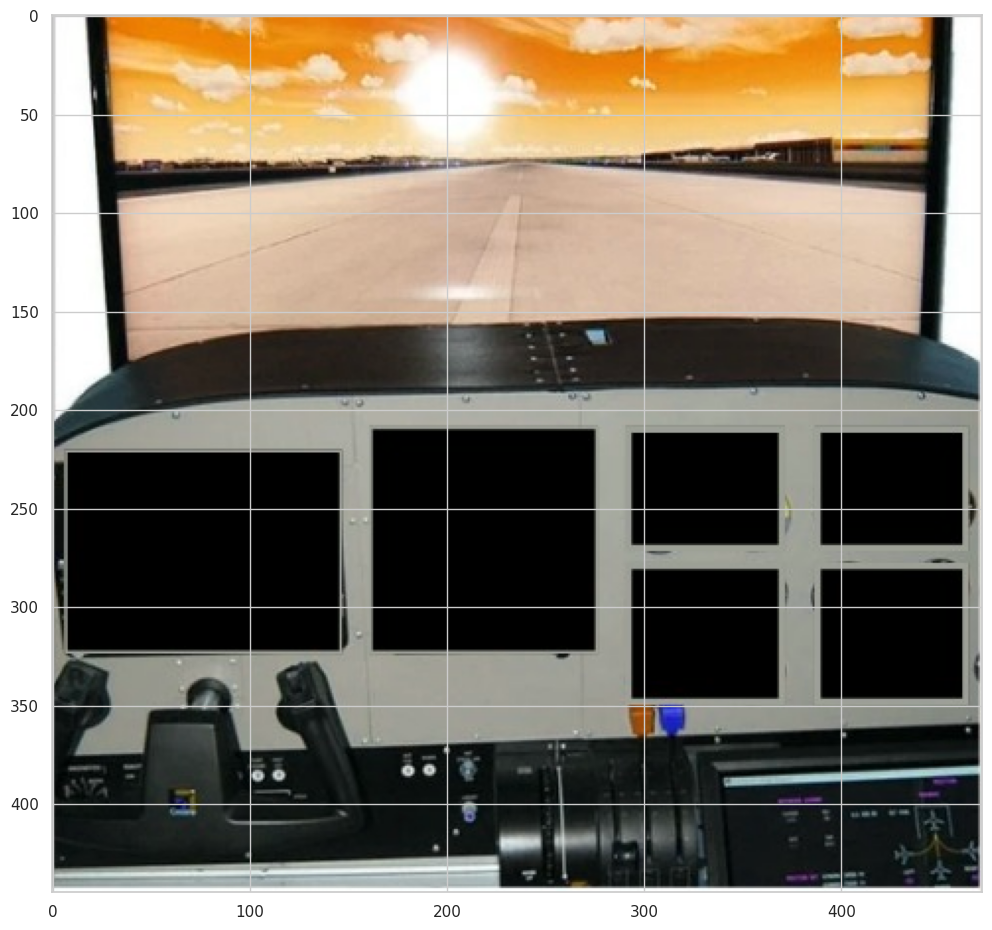

In [ ]:
imagen1 = cv2.cvtColor(imagen1, cv2.COLOR_BGR2RGB)


plt.figure(figsize=(12, 14))  # Ajustar el tamaño de la imagen
plt.imshow(imagen1)

plt.show()

In [ ]:

from google.colab.patches import cv2_imshow


In [ ]:
pip install plotly pillow

In [ ]:
from PIL import Image, ImageDraw

In [ ]:
#orden que  vamos insertando los indicadores en la cabina
#entertainment,cabin,staff,service,seat,food

# Definir las posiciones donde queremos pegar cada gráfico de indicador en la cabina
posicion= [(293,217), (395,217), (298, 285), (395, 327), (5, 225),(165,215)]

# Definir las resoluciones de cada indicador  queremos pegar cada gráfico de indicador en la cabina
resolucion = [(65,50), (65,50), (65, 50), (65, 50), (140,100),(110,110)]

#lo vamos colocando los valores de forma individual segun su poscion y resolucion del grafico

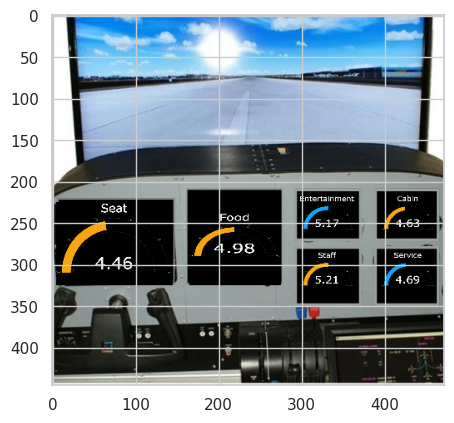

True

In [ ]:
# Cargar la imagen de fondo y el gráfico con OpenCV
imagen_fondo = imagen1
grafico = cv2.imread(seat)

# Redimensionar el gráfico
altura_deseada = 100 # Ajustar según la imagen de fondo
ancho_deseado = 140 # Ajustar según la imagen de fondo
grafico_resized = cv2.resize(grafico, (ancho_deseado, altura_deseada))

# Definir la posición donde se colocará el gráfico en la imagen de fondo
x_offset = 5
y_offset = 225

# Insertar el gráfico en la imagen de fondo
inicio_y = y_offset
fin_y = inicio_y + grafico_resized.shape[0]
inicio_x = x_offset
fin_x = inicio_x + grafico_resized.shape[1]
imagen_fondo[inicio_y:fin_y, inicio_x:fin_x] = grafico_resized

plt.imshow(imagen_fondo)

plt.show()

# Guardar la imagen resultante si es necesario
cv2.imwrite('imagen_final_con_grafico.jpg', imagen_fondo)

#cv2_imshow(imagen_fondo)

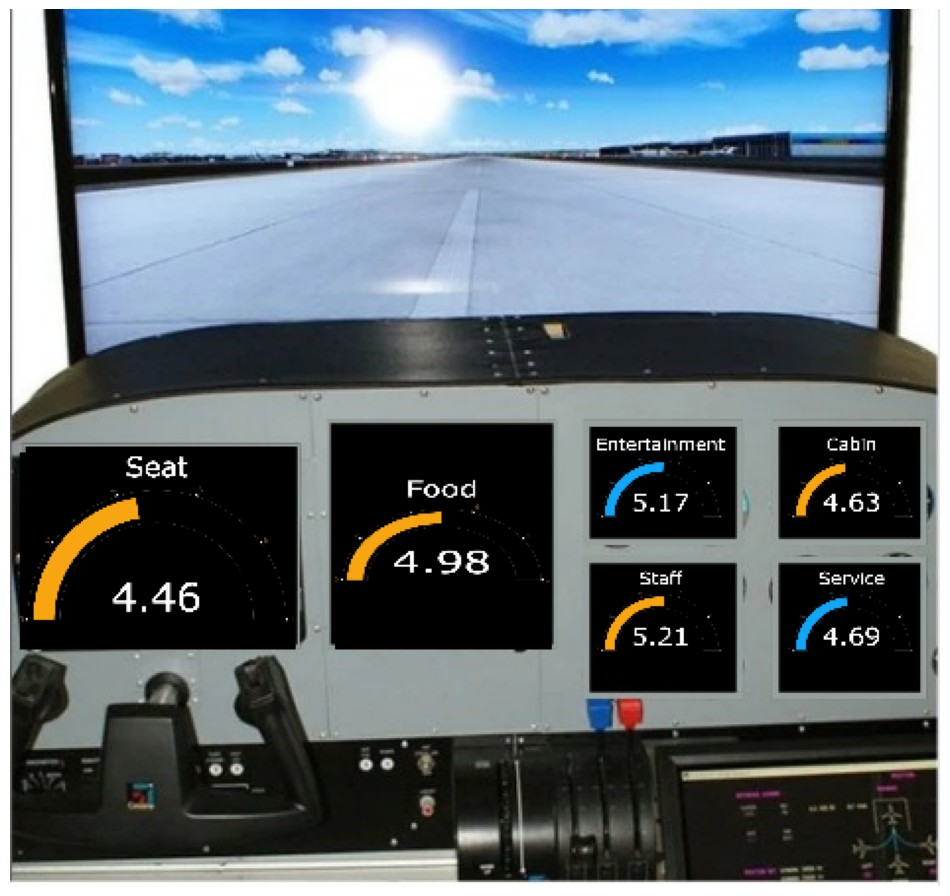

In [ ]:
plt.figure(figsize=(12, 14))
plt.imshow(imagen_fondo)
plt.axis('off')
plt.show()